#### Read in data

In [1]:
import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob,os,sys
from tqdm import tqdm
import datetime
import proplot as plot
from netCDF4 import Dataset
from wrf import getvar
import celer
%matplotlib inline

sys.path.insert(1, '/work/08350/tg876493/stampede2/python_codes/2020_TC_CRF/dev/freddy0218/tools/')
import derive_var
import read_and_proc

plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

In [2]:
############################################################################################################################################
# PCA_dict: Processed EOF objects; A_dict: Variable anomaly matrices; Af_dict: Flattened variable anomaly matrices
# *note that following EOF conventions, we derived EOFs with anomalies.
############################################################################################################################################
import pickle
path = './output/1010_ns/'
filePCA = [path+'dtheta_pca_ns',path+'urad_pca_ns',path+'vtan_pca_ns',path+'w_pca_ns',path+'uradR_pca_ns',path+'vtanR_pca_ns',path+'qv_pca_ns']
fileA = [path+'normalT_ctrl_ns',path+'normalUrad_ctrl_ns',path+'normalVtan_ctrl_ns',path+'normalw_ctrl_ns',path+'normalUradR_ctrl_ns',path+'normalVtanR_ctrl_ns',path+'normalQV_ctrl_ns']
fileAf = [path+'normalT_ctrlf_ns',path+'normalUrad_ctrlf_ns',path+'normalVtan_ctrlf_ns',path+'normalw_ctrlf_ns',path+'normalUradR_ctrlf_ns',path+'normalVtanR_ctrlf_ns',path+'normalQV_ctrlf_ns']

outputPCA,outputA,outputAf = [],[],[]
for i in range(len(filePCA)):
    with open(filePCA[i],'rb') as f:
        outputPCA.append(pickle.load(f))
    with open(fileA[i],'rb') as f:
        outputA.append(pickle.load(f))
    with open(fileAf[i],'rb') as f:
        outputAf.append(pickle.load(f))

PCA_dict = {'dtheta':outputPCA[0],'u':outputPCA[1],'v':outputPCA[2],'w':outputPCA[3],'ur':outputPCA[4],'vr':outputPCA[5],'qv':outputPCA[6]}
A_dict = {'dtheta':outputA[0],'u':outputA[1],'v':outputA[2],'w':outputA[3],'ur':outputA[4],'vr':outputA[5],'qv':outputA[6]}
Af_dict = {'dtheta':outputAf[0],'u':outputAf[1],'v':outputAf[2],'w':outputAf[3],'ur':outputAf[4],'vr':outputAf[5],'qv':outputAf[6]}

/work/08350/tg876493/stampede2/gpu_env/fred_workenv/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
print("The number of required components to explain 90% variance of each variables: ")
print("dthetadt:"+str(np.abs(PCA_dict['dtheta'].explained_variance_ratio_.cumsum()-0.9).argmin())+" "\
      "urad:"+str(np.abs(PCA_dict['u'].explained_variance_ratio_.cumsum()-0.9).argmin())+" "\
      "vtan:"+str(np.abs(PCA_dict['v'].explained_variance_ratio_.cumsum()-0.9).argmin())+" "\
      "w:"+str(np.abs(PCA_dict['w'].explained_variance_ratio_.cumsum()-0.9).argmin())+" "\
      "urad,r:"+str(np.abs(PCA_dict['ur'].explained_variance_ratio_.cumsum()-0.9).argmin())+" "\
      "vtan,r:"+str(np.abs(PCA_dict['vr'].explained_variance_ratio_.cumsum()-0.9).argmin())+" "\
     "qv:"+str(np.abs(PCA_dict['qv'].explained_variance_ratio_.cumsum()-0.9).argmin()))

The number of required components to explain 90% variance of each variables: 
dthetadt:12 urad:3 vtan:3 w:9 urad,r:4 vtan,r:3 qv:5


#### Get Time Series

In [4]:
def flatten(t):
    #https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-a-list-of-lists
    return [item for sublist in t for item in sublist]
def standardize(t,formula='I'):
    if formula=='I':
        return (t-np.min(np.asarray(t)))/(np.max(np.asarray(t))-np.min(np.asarray(t)))
    elif formula=='II':
        return (t-np.mean(np.asarray(t)))/(np.std(np.asarray(t)))

##### # Get the PCA timeseries (our input)
############################################################################################################################################
# Explains 95% of variance
no_comp = [12,4,3,3,3,9,5]
pca_timeseries = standardize(PCA_dict['dtheta'].transform(Af_dict['dtheta'])[:,0:no_comp[0]],'II')#/np.sqrt(PCA_dict['dtheta'].explained_variance_[0:no_comp[0]])
pcaur_timeseries = standardize(PCA_dict['ur'].transform(Af_dict['ur'])[:,0:no_comp[1]],'II')#/np.sqrt(PCA_dict['ur'].explained_variance_[0:no_comp[1]])
pcavr_timeseries = standardize(PCA_dict['vr'].transform(Af_dict['vr'])[:,0:no_comp[2]],'II')#/np.sqrt(PCA_dict['vr'].explained_variance_[0:no_comp[2]])
pcau_timeseries = standardize(PCA_dict['u'].transform(Af_dict['u'])[:,0:no_comp[3]],'II')#/np.sqrt(PCA_dict['u'].explained_variance_[0:no_comp[3]])
pcav_timeseries = standardize(PCA_dict['v'].transform(Af_dict['v'])[:,0:no_comp[4]],'II')#/np.sqrt(PCA_dict['v'].explained_variance_[0:no_comp[4]])
pcaw_timeseries = standardize(PCA_dict['w'].transform(Af_dict['w'])[:,0:no_comp[5]],'II')#/np.sqrt(PCA_dict['w'].explained_variance_[0:no_comp[5]])
pcaqv_timeseries = standardize(PCA_dict['qv'].transform(Af_dict['qv'])[:,0:no_comp[6]],'II')#/np.sqrt(PCA_dict['qv'].explained_variance_[0:no_comp[6]])

In [5]:
def prepare_inputdataset(inputTS=None,flat_out=np.zeros((83,12+3+3+9)),lefttimelim=None):
    def flattenlist(inlist=None):
        tempvarlist = []
        for item in inlist:
            tempvarlist.append(item)
        return flatten(tempvarlist)
    input_dataset36 = []
    for timeseries in inputTS:#[pca_timeseries_36,pcaur_timeseries_36,pcavr_timeseries_36,pcaw_timeseries_36]:
        input_dataset36.append(timeseries)
    for i in (range(inputTS[0][:,0].shape[0])):
        tempinlist = [obj[i,:] for obj in input_dataset36]
        flat_out[i,:] = flattenlist(tempinlist)
    return flat_out

flat_input_orig_dtuvw = prepare_inputdataset([pcau_timeseries[5:],pcav_timeseries[5:],pcaw_timeseries[5:],pca_timeseries[5:]],np.zeros((91,12+3+3+9)),None)
flat_input_TCr_dtuvw = prepare_inputdataset([pcaur_timeseries[:],pcavr_timeseries[:],pcaw_timeseries[5:],pca_timeseries[5:],],np.zeros((91,12+4+3+9)),None)

flat_input_orig_uv = prepare_inputdataset([pcau_timeseries[5:],pcav_timeseries[5:]],np.zeros((91,3+3)),None)
flat_input_TCr_uv = prepare_inputdataset([pcaur_timeseries[:],pcavr_timeseries[:]],np.zeros((91,4+3)),None)

flat_input_orig_uvw = prepare_inputdataset([pcau_timeseries[5:],pcav_timeseries[5:],pcaw_timeseries[5:]],np.zeros((91,3+3+9)),None)
flat_input_TCr_uvw = prepare_inputdataset([pcaur_timeseries[:],pcavr_timeseries[:],pcaw_timeseries[5:]],np.zeros((91,4+3+9)),None)

flat_input_orig_uvqv = prepare_inputdataset([pcau_timeseries[5:],pcav_timeseries[5:],pcaqv_timeseries[5:]],np.zeros((91,3+3+5)),None)
flat_input_TCr_uvqv = prepare_inputdataset([pcaur_timeseries[:],pcavr_timeseries[:],pcaqv_timeseries[5:]],np.zeros((91,4+3+5)),None)

flat_input_orig_uvwqv = prepare_inputdataset([pcau_timeseries[5:],pcav_timeseries[5:],pcaw_timeseries[5:],pcaqv_timeseries[5:]],np.zeros((91,3+3+9+5)),None)
flat_input_TCr_uvwqv = prepare_inputdataset([pcaur_timeseries[:],pcavr_timeseries[:],pcaw_timeseries[5:],pcaqv_timeseries[5:]],np.zeros((91,4+3+9+5)),None)

flat_input_orig_dtuvwqv = prepare_inputdataset([pcau_timeseries[5:],pcav_timeseries[5:],pcaw_timeseries[5:],pca_timeseries[5:],pcaqv_timeseries[5:]],np.zeros((91,12+3+3+9+5)),None)
flat_input_TCr_dtuvwqv = prepare_inputdataset([pcaur_timeseries[:],pcavr_timeseries[:],pcaw_timeseries[5:],pca_timeseries[5:],pcaqv_timeseries[5:]],np.zeros((91,12+4+3+9+5)),None)    

In [6]:
CTRLinputdataset_dict = {'u-v-w':flat_input_orig_uvw,'u-v':flat_input_orig_uv,'dt-u-v-w':flat_input_orig_dtuvw,'dt-u-v-w-qv':flat_input_orig_dtuvwqv,\
                        'u-v-w-qv':flat_input_orig_uvwqv,'u-v-qv':flat_input_orig_uvqv}

In [7]:
del A_dict,Af_dict

#### Do the sensitivity experiments

In [8]:
#Function####################################################
import json,pickle
def nearest_index(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx.values
def save_to_pickle(loc=None,var=None):
    with open(loc,"wb") as f:
        pickle.dump(var,f)
    return None

def do_PCA(var=None,timezoom=None,smooth='Yes',gaussian=0.9,fromcenter='Yes',inradius=None,outradius=None,donormal='Yes',doPCA='Yes'):
    """
    Var: Input variable (must have 4 dimensions! Time-pres-theta-radius)
    """
    if smooth=='Yes':
        from scipy.ndimage import gaussian_filter
        normal_var = []
        if donormal=='Yes':
            for presindex in range(len(var[0,:,0,0])):
                normal_var.append(gaussian_filter(normalize_inner(var[:,presindex,:,:],outradius,'Yes'),sigma=gaussian))
        elif donormal=='No':
            for presindex in range(len(var[0,:,0,0])):
                normal_var.append(gaussian_filter(normalize_inner(var[:,presindex,:,:],outradius,'No'),sigma=gaussian))            
        normal_var = np.swapaxes(np.asarray(normal_var),0,1)
    else:
        normal_var = []
        for presindex in range(len(var[0,:,0,0])):
            normal_var.append(normalize_inner(var[:,presindex,:,:],outradius))
        normal_var = np.swapaxes(np.asarray(normal_var),0,1)
    if fromcenter=='Yes':
        normal_varf = np.asarray([normal_var[i,:,:,:outradius].flatten() \
                                  for i in range(len(normal_var[timezoom[0]:timezoom[1],0,0,0]))])
    elif fromcenter=='No':
        normal_varf = np.asarray([normal_var[i,:,:,inradius:outradius].flatten() \
                                  for i in range(len(normal_var[timezoom[0]:timezoom[1],0,0,0]))])        
    print("--Finish preprocesing--")
    if doPCA=='Yes':
        from sklearn.decomposition import PCA
        import time
        start_time = time.time()
        skpcaVAR = PCA()
        skpcaVAR.fit(normal_varf.copy())
        print("--- %s seconds ---" % (time.time() - start_time))
        return skpcaVAR,normal_var,normal_varf
    else:
        return normal_var,normal_varf

def forward_diff(arrayin=None,delta=None,axis=None,LT=1):
    result = []
    if axis==0:
        if LT==1:
            for i in range(0,arrayin.shape[axis]-1):
                temp = (arrayin[i+1,:]-arrayin[i,:])/(LT*delta)
                result.append(temp)
            return np.asarray(result)
        elif LT==2:
            for i in range(0,arrayin.shape[axis]-2):
                temp = (arrayin[i+2,:]-arrayin[i,:])/(LT*delta)
                result.append(temp)
            return np.asarray(result)
        elif LT==3:
            for i in range(0,arrayin.shape[axis]-3):
                temp = (arrayin[i+3,:]-arrayin[i,:])/(LT*delta)
                result.append(temp)
            return np.asarray(result)
        
def normalize_inner(var=None,outerradius=None,standard='Yes'):
    PWper_ctrl = []
    for indx in range(len(var[:,0,0])):
        temp = var[indx,:,:outerradius]-np.nanmean(var[indx,:,:outerradius],axis=(0,1))
        if standard=='Yes':
            PWper_ctrl.append((temp-np.nanmean(temp))/np.nanstd(temp))
        elif standard=='No':
            PWper_ctrl.append((temp))
    del temp
    return np.asarray(PWper_ctrl)

In [9]:
origin_path = '/scratch/06040/tg853394/tc/output/redux/maria/'

#############################################################
ctrlvar_dict = read_and_proc.read_some_azimuth_fields(fileloc=[origin_path+'ctl/azim_W_0-144hr.nc',origin_path+'ctl/azim_QVAPOR_0-144hr.nc'],fieldname=['W','QVAPOR'])
ncrf60var_dict = read_and_proc.read_some_azimuth_fields(fileloc=[origin_path+'ncrf_60h/azim_W_60-144hr.nc',origin_path+'ncrf_60h/azim_QVAPOR_60-144hr.nc'],fieldname=['W','QVAPOR'])
ncrf36var_dict = read_and_proc.read_some_azimuth_fields(fileloc=[origin_path+'ncrf_36h/azim_W_36-144hr.nc',origin_path+'ncrf_36h/azim_QVAPOR_36-144hr.nc'],fieldname=['W','QVAPOR'])
lwcrfvar_dict = read_and_proc.read_some_azimuth_fields(fileloc=[origin_path+'lwcrf/azim_W_36-144hr.nc',origin_path+'lwcrf/azim_QVAPOR_36-144hr.nc'],fieldname=['W','QVAPOR'])

path = '/work2/08350/tg876493/stampede2/python_codes/tcg_radiation/output/'
file = [path+'ctrl_thetaall',path+'ncrf36_thetaall',path+'ncrf60_thetaall',path+'lwcrf_thetaall']
output = []
for i in range(len(file)):
    with open(file[i],'rb') as f:
        output.append(pickle.load(f))
theta_dict = {'CTRL_theta':output[0],'NCRF36_theta':output[1],'NCRF60_theta':output[2],'LWCRF_theta':output[3]}
# To be consistent with azimuthal files
########################################################################################################
ctrl_thetaA,ncrf36_thetaA,ncrf60_thetaA,lwcrf_thetaA = np.swapaxes(np.asarray(theta_dict['CTRL_theta']),0,1),\
np.swapaxes(np.asarray(theta_dict['NCRF36_theta']),0,1),np.swapaxes(np.asarray(theta_dict['NCRF60_theta']),0,1),np.swapaxes(np.asarray(theta_dict['LWCRF_theta']),0,1)
del output,theta_dict,outputPCA,outputA,outputAf
# Heating Rate
#########################################################################################################
r0,r200=(nearest_index(ctrlvar_dict['W']['W'].radius,0),nearest_index(ctrlvar_dict['W']['W'].radius,200))
r300,r500=(nearest_index(ctrlvar_dict['W']['W'].radius,300),nearest_index(ctrlvar_dict['W']['W'].radius,500))

In [10]:
########################################################################################################################
# Patch data
########################################################################################################################
NCRF36_w = read_and_proc.add_ctrl_before_senstart(ctrlvar_dict['W']['W'],ncrf36var_dict['W']['W'],'NCRF36','Yes')
NCRF60_w = read_and_proc.add_ctrl_before_senstart(ctrlvar_dict['W']['W'],ncrf60var_dict['W']['W'],'NCRF60','Yes')
LWCRF_w = read_and_proc.add_ctrl_before_senstart(ctrlvar_dict['W']['W'],lwcrfvar_dict['W']['W'],'NCRF36','Yes')

NCRF36_qv = read_and_proc.add_ctrl_before_senstart(ctrlvar_dict['QVAPOR']['QVAPOR'],ncrf36var_dict['QVAPOR']['QVAPOR'],'NCRF36','Yes')
NCRF60_qv = read_and_proc.add_ctrl_before_senstart(ctrlvar_dict['QVAPOR']['QVAPOR'],ncrf60var_dict['QVAPOR']['QVAPOR'],'NCRF60','Yes')
LWCRF_qv = read_and_proc.add_ctrl_before_senstart(ctrlvar_dict['QVAPOR']['QVAPOR'],lwcrfvar_dict['QVAPOR']['QVAPOR'],'NCRF36','Yes')
ncrf36_thetaA_n,ncrf60_thetaA_n,lwcrf_thetaA_n = read_and_proc.add_ctrl_before_senstart(ctrl_thetaA,ncrf36_thetaA,'NCRF36','Yes'),\
read_and_proc.add_ctrl_before_senstart(ctrl_thetaA,ncrf60_thetaA,'NCRF60','Yes'),read_and_proc.add_ctrl_before_senstart(ctrl_thetaA,lwcrf_thetaA,'NCRF36','Yes')

########################################################################################################################
# Derive buoyancy (Pendergrass and Willoughby 2009: p.806)
########################################################################################################################
#ncrf36_buoyA_n,ncrf60_buoyA_n,lwcrf_buoyA_n = 9.81*np.log(ncrf36_thetaA_n/273.16),9.81*np.log(ncrf60_thetaA_n/273.16),9.81*np.log(lwcrf_thetaA_n/273.16)
del ctrl_thetaA,ncrf36_thetaA,ncrf60_thetaA,ncrf36var_dict,ncrf60var_dict,lwcrfvar_dict

In [11]:
from scipy.ndimage import gaussian_filter
###################################################################
# Cut off time
###################################################################
ctrl_t2,ctrl_t4 = nearest_index(ctrlvar_dict['W']['W'].time/24,1)-1,nearest_index(ctrlvar_dict['W']['W'].time/24,5)-1
###################################################################
# Heating Rate
###################################################################
buoy='Yes'
if buoy=='Yes':
    ncrf36_thetagrad_b,ncrf60_thetagrad_b,lwcrf_thetagrad_b = forward_diff(gaussian_filter(ncrf36_buoyA_n,sigma=[3,0,0,0]),60*60,0),\
    forward_diff(gaussian_filter(ncrf60_buoyA_n,sigma=[3,0,0,0]),60*60,0),forward_diff(gaussian_filter(lwcrf_buoyA_n,sigma=[3,0,0,0]),60*60,0)
else:
    ncrf36_thetagrad_b,ncrf60_thetagrad_b,lwcrf_thetagrad_b = forward_diff(gaussian_filter(ncrf36_thetaA_n,sigma=[3,0,0,0]),60*60,0),\
    forward_diff(gaussian_filter(ncrf60_thetaA_n,sigma=[3,0,0,0]),60*60,0),forward_diff(gaussian_filter(lwcrf_thetaA_n,sigma=[3,0,0,0]),60*60,0)

_,normalTncrf36f = do_PCA(var=ncrf36_thetagrad_b,timezoom=[ctrl_t2,ctrl_t4],smooth='Yes',
                                              gaussian=[0,0,0],fromcenter='Yes',inradius=None,outradius=r500,donormal='No',doPCA='No')
_,normalTncrf60f = do_PCA(var=ncrf60_thetagrad_b,timezoom=[ctrl_t2,ctrl_t4],smooth='Yes',
                                              gaussian=[0,0,0],fromcenter='Yes',inradius=None,outradius=r500,donormal='No',doPCA='No')
_,normalTlwcrff = do_PCA(var=lwcrf_thetagrad_b,timezoom=[ctrl_t2,ctrl_t4],smooth='Yes',
                                              gaussian=[0,0,0],fromcenter='Yes',inradius=None,outradius=r500,donormal='No',doPCA='No')

# w
_,normalWncrf36f = do_PCA(var=NCRF36_w,timezoom=[ctrl_t2,ctrl_t4],smooth='Yes',
                                              gaussian=[3,0,0],fromcenter='Yes',inradius=None,outradius=r500,donormal='No',doPCA='No')
_,normalWncrf60f = do_PCA(var=NCRF60_w,timezoom=[ctrl_t2,ctrl_t4],smooth='Yes',
                                              gaussian=[3,0,0],fromcenter='Yes',inradius=None,outradius=r500,donormal='No',doPCA='No')
_,normalWlwcrff = do_PCA(var=LWCRF_w,timezoom=[ctrl_t2,ctrl_t4],smooth='Yes',
                                              gaussian=[3,0,0],fromcenter='Yes',inradius=None,outradius=r500,donormal='No',doPCA='No')

# qv
_,normalQVncrf36f = do_PCA(var=NCRF36_qv,timezoom=[ctrl_t2,ctrl_t4],smooth='Yes',
                                              gaussian=[3,0,0],fromcenter='Yes',inradius=None,outradius=r500,donormal='No',doPCA='No')
_,normalQVncrf60f = do_PCA(var=NCRF60_qv,timezoom=[ctrl_t2,ctrl_t4],smooth='Yes',
                                              gaussian=[3,0,0],fromcenter='Yes',inradius=None,outradius=r500,donormal='No',doPCA='No')
_,normalQVlwcrff = do_PCA(var=LWCRF_qv,timezoom=[ctrl_t2,ctrl_t4],smooth='Yes',
                                              gaussian=[3,0,0],fromcenter='Yes',inradius=None,outradius=r500,donormal='No',doPCA='No')

--Finish preprocesing--
--Finish preprocesing--
--Finish preprocesing--
--Finish preprocesing--
--Finish preprocesing--
--Finish preprocesing--
--Finish preprocesing--
--Finish preprocesing--
--Finish preprocesing--


In [12]:
path = './output/1010_ns/'
file = [path+'normalUradR_ncrf36f_ns',path+'normalUradR_ncrf60f_ns',path+'normalUradR_lwcrff_ns',path+'normalVtanR_ncrf36f_ns',path+'normalVtanR_ncrf60f_ns',path+'normalVtanR_lwcrff_ns']
file2 = [path+'normalUrad_ncrf36f_ns',path+'normalUrad_ncrf60f_ns',path+'normalUrad_lwcrff_ns',path+'normalVtan_ncrf36f_ns',path+'normalVtan_ncrf60f_ns',path+'normalVtan_lwcrff_ns']
output = []
for i in range(len(file)):
    with open(file[i],'rb') as f:
        output.append(pickle.load(f))
normalUradRncrf36f,normalUradRncrf60f,normalUradRlwcrff = output[0],output[1],output[2]
normalVtanRncrf36f,normalVtanRncrf60f,normalVtanRlwcrff = output[3],output[4],output[5]
del output

output = []
for i in range(len(file2)):
    with open(file2[i],'rb') as f:
        output.append(pickle.load(f))
normalUradncrf36f,normalUradncrf60f,normalUradlwcrff = output[0],output[1],output[2]
normalVtanncrf36f,normalVtanncrf60f,normalVtanlwcrff = output[3],output[4],output[5]
#del NCRF36_u,NCRF36_v,NCRF36_w,NCRF60_u,NCRF60_v,NCRF60_w,output

In [24]:
pca_timeseries_36.shape,pca_timeseries_60.shape,pcau_timeseries.shape

((96, 12), (96, 12), (96, 3))

In [13]:
pca_timeseries_36 = standardize(PCA_dict['dtheta'].transform(normalTncrf36f)[:,0:no_comp[0]],'II')
pcaur_timeseries_36 = standardize(PCA_dict['ur'].transform(normalUradRncrf36f)[:,0:no_comp[1]],'II')
pcavr_timeseries_36 = standardize(PCA_dict['vr'].transform(normalVtanRncrf36f)[:,0:no_comp[2]],'II')
pcau_timeseries_36 = standardize(PCA_dict['u'].transform(normalUradncrf36f)[:,0:no_comp[3]],'II')
pcav_timeseries_36 = standardize(PCA_dict['v'].transform(normalVtanncrf36f)[:,0:no_comp[4]],'II')
pcaw_timeseries_36 = standardize(PCA_dict['w'].transform(normalWncrf36f)[:,0:no_comp[5]],'II')
pcaqv_timeseries_36 = standardize(PCA_dict['qv'].transform(normalWncrf36f)[:,0:no_comp[6]],'II')

pca_timeseries_60 = standardize(PCA_dict['dtheta'].transform(normalTncrf60f)[:,0:no_comp[0]],'II')
pcaur_timeseries_60 = standardize(PCA_dict['ur'].transform(normalUradRncrf60f)[:,0:no_comp[1]],'II')
pcavr_timeseries_60 = standardize(PCA_dict['vr'].transform(normalVtanRncrf60f)[:,0:no_comp[2]],'II')
pcau_timeseries_60 = standardize(PCA_dict['u'].transform(normalUradncrf60f)[:,0:no_comp[3]],'II')
pcav_timeseries_60 = standardize(PCA_dict['v'].transform(normalVtanncrf60f)[:,0:no_comp[4]],'II')
pcaw_timeseries_60 = standardize(PCA_dict['w'].transform(normalWncrf60f)[:,0:no_comp[5]],'II')
pcaqv_timeseries_60 = standardize(PCA_dict['qv'].transform(normalWncrf60f)[:,0:no_comp[6]],'II')

pca_timeseries_lwcrf = standardize(PCA_dict['dtheta'].transform(normalTlwcrff)[:,0:no_comp[0]],'II')
pcaur_timeseries_lwcrf = standardize(PCA_dict['ur'].transform(normalUradRlwcrff)[:,0:no_comp[1]],'II')
pcavr_timeseries_lwcrf = standardize(PCA_dict['vr'].transform(normalVtanRlwcrff)[:,0:no_comp[2]],'II')
pcau_timeseries_lwcrf = standardize(PCA_dict['u'].transform(normalUradlwcrff)[:,0:no_comp[3]],'II')
pcav_timeseries_lwcrf = standardize(PCA_dict['v'].transform(normalVtanlwcrff)[:,0:no_comp[4]],'II')
pcaw_timeseries_lwcrf = standardize(PCA_dict['w'].transform(normalWlwcrff)[:,0:no_comp[5]],'II')
pcaqv_timeseries_lwcrf = standardize(PCA_dict['qv'].transform(normalWlwcrff)[:,0:no_comp[6]],'II')

In [14]:
#flat_input_orig_36 = prepare_inputdataset([pcau_timeseries_36[36-ctrl_t2-5:],pcav_timeseries_36[36-ctrl_t2-5:],pcaw_timeseries_36[36-ctrl_t2:]],np.zeros((83,3+3+9)),ctrl_t2)
#flat_input_TCr_36 = prepare_inputdataset([pcaur_timeseries_36[36-ctrl_t2-5:],pcavr_timeseries_36[36-ctrl_t2-5:],pcaw_timeseries_36[36-ctrl_t2:]],np.zeros((83,4+3+9)),ctrl_t2)

#flat_input_orig_60 = prepare_inputdataset([pcau_timeseries_60[60-ctrl_t2-5:],pcav_timeseries_60[60-ctrl_t2-5:],pcaw_timeseries_60[60-ctrl_t2:]],np.zeros((59,3+3+9)),ctrl_t2)
#flat_input_TCr_60 = prepare_inputdataset([pcaur_timeseries_60[60-ctrl_t2-5:],pcavr_timeseries_60[60-ctrl_t2-5:],pcaw_timeseries_60[60-ctrl_t2:]],np.zeros((59,4+3+9)),ctrl_t2)

#flat_input_orig_lwcrf = prepare_inputdataset([pcau_timeseries_lwcrf[36-ctrl_t2-5:],pcav_timeseries_lwcrf[36-ctrl_t2-5:],pcaw_timeseries_lwcrf[36-ctrl_t2:]],np.zeros((83,3+3+9)),ctrl_t2)
#flat_input_TCr_lwcrf = prepare_inputdataset([pcaur_timeseries_lwcrf[36-ctrl_t2-5:],pcavr_timeseries_lwcrf[36-ctrl_t2-5:],pcaw_timeseries_lwcrf[36-ctrl_t2:]],np.zeros((83,4+3+9)),ctrl_t2)

flat_input_orig_36_dtuvw = prepare_inputdataset([pcau_timeseries_36[36-ctrl_t2-5:],pcav_timeseries_36[36-ctrl_t2-5:],pcaw_timeseries_36[36-ctrl_t2:],pca_timeseries_36[36-ctrl_t2:]],np.zeros((83,12+3+3+9)),ctrl_t2)
flat_input_TCr_36_dtuvw = prepare_inputdataset([pcaur_timeseries_36[36-ctrl_t2-5:],pcavr_timeseries_36[36-ctrl_t2-5:],pcaw_timeseries_36[36-ctrl_t2:],pca_timeseries_36[36-ctrl_t2:]],np.zeros((83,12+4+3+9)),ctrl_t2)
flat_input_orig_36_uv = prepare_inputdataset([pcau_timeseries_36[36-ctrl_t2-5:],pcav_timeseries_36[36-ctrl_t2-5:]],np.zeros((83,3+3)),ctrl_t2)
flat_input_TCr_36_uv = prepare_inputdataset([pcaur_timeseries_36[36-ctrl_t2-5:],pcavr_timeseries_36[36-ctrl_t2-5:]],np.zeros((83,4+3)),ctrl_t2)
flat_input_orig_36_uvw = prepare_inputdataset([pcau_timeseries_36[36-ctrl_t2-5:],pcav_timeseries_36[36-ctrl_t2-5:],pcaw_timeseries_36[36-ctrl_t2:]],np.zeros((83,3+3+9)),ctrl_t2)
flat_input_TCr_36_uvw = prepare_inputdataset([pcaur_timeseries_36[36-ctrl_t2-5:],pcavr_timeseries_36[36-ctrl_t2-5:],pcaw_timeseries_36[36-ctrl_t2:]],np.zeros((83,4+3+9)),ctrl_t2)    
flat_input_orig_36_dtuvwqv = prepare_inputdataset([pcau_timeseries_36[36-ctrl_t2-5:],pcav_timeseries_36[36-ctrl_t2-5:],pcaw_timeseries_36[36-ctrl_t2:],pca_timeseries_36[36-ctrl_t2:],pcaqv_timeseries_36[36-ctrl_t2:]],\
                                                  np.zeros((83,12+3+3+9+5)),ctrl_t2)
flat_input_TCr_36_dtuvwqv = prepare_inputdataset([pcaur_timeseries_36[36-ctrl_t2-5:],pcavr_timeseries_36[36-ctrl_t2-5:],pcaw_timeseries_36[36-ctrl_t2:],pca_timeseries_36[36-ctrl_t2:],pcaqv_timeseries_36[36-ctrl_t2:]],\
                                                 np.zeros((83,12+4+3+9+5)),ctrl_t2)    
flat_input_orig_36_uvwqv = prepare_inputdataset([pcau_timeseries_36[36-ctrl_t2-5:],pcav_timeseries_36[36-ctrl_t2-5:],pcaw_timeseries_36[36-ctrl_t2:],pcaqv_timeseries_36[36-ctrl_t2:]],\
                                                  np.zeros((83,3+3+9+5)),ctrl_t2)
flat_input_TCr_36_uvwqv = prepare_inputdataset([pcaur_timeseries_36[36-ctrl_t2-5:],pcavr_timeseries_36[36-ctrl_t2-5:],pcaw_timeseries_36[36-ctrl_t2:],pcaqv_timeseries_36[36-ctrl_t2:]],\
                                                 np.zeros((83,4+3+9+5)),ctrl_t2)
flat_input_orig_36_uvqv = prepare_inputdataset([pcau_timeseries_36[36-ctrl_t2-5:],pcav_timeseries_36[36-ctrl_t2-5:],pcaqv_timeseries_36[36-ctrl_t2:]],np.zeros((83,3+3+5)),ctrl_t2)
flat_input_TCr_36_uvqv = prepare_inputdataset([pcaur_timeseries_36[36-ctrl_t2-5:],pcavr_timeseries_36[36-ctrl_t2-5:],pcaqv_timeseries_36[36-ctrl_t2:]],np.zeros((83,4+3+5)),ctrl_t2)

flat_input_orig_60_dtuvw = prepare_inputdataset([pcau_timeseries_60[60-ctrl_t2-5:],pcav_timeseries_60[60-ctrl_t2-5:],pcaw_timeseries_60[60-ctrl_t2:],pca_timeseries_60[60-ctrl_t2:]],np.zeros((59,12+3+3+9)),ctrl_t2)
flat_input_TCr_60_dtuvw = prepare_inputdataset([pcaur_timeseries_60[60-ctrl_t2-5:],pcavr_timeseries_60[60-ctrl_t2-5:],pcaw_timeseries_60[60-ctrl_t2:],pca_timeseries_60[60-ctrl_t2:]],np.zeros((59,12+4+3+9)),ctrl_t2)
flat_input_orig_60_uv = prepare_inputdataset([pcau_timeseries_60[60-ctrl_t2-5:],pcav_timeseries_60[60-ctrl_t2-5:]],np.zeros((59,3+3)),ctrl_t2)
flat_input_TCr_60_uv = prepare_inputdataset([pcaur_timeseries_60[60-ctrl_t2-5:],pcavr_timeseries_60[60-ctrl_t2-5:]],np.zeros((59,4+3)),ctrl_t2)
flat_input_orig_60_uvw = prepare_inputdataset([pcau_timeseries_60[60-ctrl_t2-5:],pcav_timeseries_60[60-ctrl_t2-5:],pcaw_timeseries_60[60-ctrl_t2:]],np.zeros((59,3+3+9)),ctrl_t2)
flat_input_TCr_60_uvw = prepare_inputdataset([pcaur_timeseries_60[60-ctrl_t2-5:],pcavr_timeseries_60[60-ctrl_t2-5:],pcaw_timeseries_60[60-ctrl_t2-5:]],np.zeros((59,4+3+9)),ctrl_t2)    
flat_input_orig_60_dtuvwqv = prepare_inputdataset([pcau_timeseries_60[60-ctrl_t2-5:],pcav_timeseries_60[60-ctrl_t2-5:],pcaw_timeseries_60[60-ctrl_t2:],pca_timeseries_60[60-ctrl_t2:],pcaqv_timeseries_60[60-ctrl_t2:]],\
                                                  np.zeros((59,12+3+3+9+5)),ctrl_t2)
flat_input_TCr_60_dtuvwqv = prepare_inputdataset([pcaur_timeseries_60[60-ctrl_t2-5:],pcavr_timeseries_60[:],pcaw_timeseries_60[60-ctrl_t2:],pca_timeseries_60[60-ctrl_t2:],pcaqv_timeseries_60[60-ctrl_t2:]],\
                                                 np.zeros((59,12+4+3+9+5)),ctrl_t2)  
flat_input_orig_60_uvwqv = prepare_inputdataset([pcau_timeseries_60[60-ctrl_t2-5:],pcav_timeseries_60[60-ctrl_t2-5:],pcaw_timeseries_60[60-ctrl_t2:],pcaqv_timeseries_60[60-ctrl_t2:]],\
                                                  np.zeros((59,3+3+9+5)),ctrl_t2)
flat_input_TCr_60_uvwqv = prepare_inputdataset([pcaur_timeseries_60[60-ctrl_t2-5:],pcavr_timeseries_60[:],pcaw_timeseries_60[60-ctrl_t2:],pcaqv_timeseries_60[60-ctrl_t2:]],\
                                                 np.zeros((59,4+3+9+5)),ctrl_t2) 
flat_input_orig_60_uvqv = prepare_inputdataset([pcau_timeseries_60[60-ctrl_t2-5:],pcav_timeseries_60[60-ctrl_t2-5:],pcaqv_timeseries_60[60-ctrl_t2:]],np.zeros((59,3+3+5)),ctrl_t2)
flat_input_TCr_60_uvqv = prepare_inputdataset([pcaur_timeseries_60[60-ctrl_t2-5:],pcavr_timeseries_60[:],pcaqv_timeseries_60[60-ctrl_t2:]],np.zeros((59,4+3+5)),ctrl_t2) 

flat_input_orig_lwcrf_dtuvw = prepare_inputdataset([pcau_timeseries_lwcrf[36-ctrl_t2-5:],pcav_timeseries_lwcrf[36-ctrl_t2-5:],pcaw_timeseries_lwcrf[36-ctrl_t2:],pca_timeseries_lwcrf[36-ctrl_t2:]],np.zeros((83,12+3+3+9)),ctrl_t2)
flat_input_TCr_lwcrf_dtuvw = prepare_inputdataset([pcaur_timeseries_lwcrf[36-ctrl_t2-5:],pcavr_timeseries_lwcrf[36-ctrl_t2-5:],pcaw_timeseries_lwcrf[36-ctrl_t2:],pca_timeseries_lwcrf[36-ctrl_t2:]],np.zeros((83,12+4+3+9)),ctrl_t2)
flat_input_orig_lwcrf_uv = prepare_inputdataset([pcau_timeseries_lwcrf[36-ctrl_t2-5:],pcav_timeseries_lwcrf[36-ctrl_t2-5:]],np.zeros((83,3+3)),ctrl_t2)
flat_input_TCr_lwcrf_uv = prepare_inputdataset([pcaur_timeseries_lwcrf[36-ctrl_t2-5:],pcavr_timeseries_lwcrf[36-ctrl_t2-5:]],np.zeros((83,4+3)),ctrl_t2)
flat_input_orig_lwcrf_uvw = prepare_inputdataset([pcau_timeseries_lwcrf[36-ctrl_t2-5:],pcav_timeseries_lwcrf[36-ctrl_t2-5:],pcaw_timeseries_lwcrf[36-ctrl_t2:]],np.zeros((83,3+3+9)),ctrl_t2)
flat_input_TCr_lwcrf_uvw = prepare_inputdataset([pcaur_timeseries_lwcrf[36-ctrl_t2-5:],pcavr_timeseries_lwcrf[36-ctrl_t2-5:],pcaw_timeseries_lwcrf[36-ctrl_t2:]],np.zeros((83,4+3+9)),ctrl_t2)    
flat_input_orig_lwcrf_dtuvwqv = prepare_inputdataset([pcau_timeseries_lwcrf[36-ctrl_t2-5:],pcav_timeseries_lwcrf[36-ctrl_t2-5:],pcaw_timeseries_lwcrf[36-ctrl_t2:],pca_timeseries_lwcrf[36-ctrl_t2:],pcaqv_timeseries_lwcrf[36-ctrl_t2:]],\
                                                  np.zeros((83,12+3+3+9+5)),ctrl_t2)
flat_input_TCr_lwcrf_dtuvwqv = prepare_inputdataset([pcaur_timeseries_lwcrf[36-ctrl_t2-5:],pcavr_timeseries_lwcrf[36-ctrl_t2-5:],pcaw_timeseries_lwcrf[36-ctrl_t2:],pca_timeseries_lwcrf[36-ctrl_t2:],pcaqv_timeseries_lwcrf[36-ctrl_t2:]],\
                                                 np.zeros((83,12+4+3+9+5)),ctrl_t2)    
flat_input_orig_lwcrf_uvwqv = prepare_inputdataset([pcau_timeseries_lwcrf[36-ctrl_t2-5:],pcav_timeseries_lwcrf[36-ctrl_t2-5:],pcaw_timeseries_lwcrf[36-ctrl_t2:],pcaqv_timeseries_lwcrf[36-ctrl_t2:]],\
                                                  np.zeros((83,3+3+9+5)),ctrl_t2)
flat_input_TCr_lwcrf_uvwqv = prepare_inputdataset([pcaur_timeseries_lwcrf[36-ctrl_t2-5:],pcavr_timeseries_lwcrf[36-ctrl_t2-5:],pcaw_timeseries_lwcrf[36-ctrl_t2:],pcaqv_timeseries_lwcrf[36-ctrl_t2:]],\
                                                 np.zeros((83,4+3+9+5)),ctrl_t2) 
flat_input_orig_lwcrf_uvqv = prepare_inputdataset([pcau_timeseries_lwcrf[36-ctrl_t2-5:],pcav_timeseries_lwcrf[36-ctrl_t2-5:],pcaqv_timeseries_lwcrf[36-ctrl_t2:]],\
                                                  np.zeros((83,3+3+5)),ctrl_t2)
flat_input_TCr_lwcrf_uvqv = prepare_inputdataset([pcaur_timeseries_lwcrf[36-ctrl_t2-5:],pcavr_timeseries_lwcrf[36-ctrl_t2-5:],pcaqv_timeseries_lwcrf[36-ctrl_t2:]],\
                                                 np.zeros((83,4+3+5)),ctrl_t2) 

In [15]:
input_orig_dtuvw = np.concatenate((flat_input_orig_dtuvw,flat_input_orig_36_dtuvw,flat_input_orig_60_dtuvw,flat_input_orig_lwcrf_dtuvw),axis=0)
input_orig_uv = np.concatenate((flat_input_orig_uv,flat_input_orig_36_uv,flat_input_orig_60_uv,flat_input_orig_lwcrf_uv),axis=0)
input_orig_uvw = np.concatenate((flat_input_orig_uvw,flat_input_orig_36_uvw,flat_input_orig_60_uvw,flat_input_orig_lwcrf_uvw),axis=0)
input_orig_uvqv = np.concatenate((flat_input_orig_uvqv,flat_input_orig_36_uvqv,flat_input_orig_60_uvqv,flat_input_orig_lwcrf_uvqv),axis=0)
input_orig_dtuvwqv = np.concatenate((flat_input_orig_dtuvwqv,flat_input_orig_36_dtuvwqv,flat_input_orig_60_dtuvwqv,flat_input_orig_lwcrf_dtuvwqv),axis=0)
input_orig_uvwqv = np.concatenate((flat_input_orig_uvwqv,flat_input_orig_36_uvwqv,flat_input_orig_60_uvwqv,flat_input_orig_lwcrf_uvwqv),axis=0)

input_TCr_dtuvw = np.concatenate((flat_input_TCr_dtuvw,flat_input_TCr_36_dtuvw,flat_input_TCr_60_dtuvw,flat_input_TCr_lwcrf_dtuvw),axis=0)
input_TCr_uv = np.concatenate((flat_input_TCr_uv,flat_input_TCr_36_uv,flat_input_TCr_60_uv,flat_input_TCr_lwcrf_uv),axis=0)
input_TCr_uvw = np.concatenate((flat_input_TCr_uvw,flat_input_TCr_36_uvw,flat_input_TCr_60_uvw,flat_input_TCr_lwcrf_uvw),axis=0)
input_TCr_uvqv = np.concatenate((flat_input_TCr_uvqv,flat_input_TCr_36_uvqv,flat_input_TCr_60_uvqv,flat_input_TCr_lwcrf_uvqv),axis=0)
input_TCr_dtuvwqv = np.concatenate((flat_input_TCr_dtuvwqv,flat_input_TCr_36_dtuvwqv,flat_input_TCr_60_dtuvwqv,flat_input_TCr_lwcrf_dtuvwqv),axis=0)
input_TCr_uvwqv = np.concatenate((flat_input_TCr_uvwqv,flat_input_TCr_36_uvwqv,flat_input_TCr_60_uvwqv,flat_input_TCr_lwcrf_uvwqv),axis=0)
#input_TCr = np.concatenate((flat_input_TCr,flat_input_TCr_36,flat_input_TCr_60,flat_input_TCr_lwcrf),axis=0)

#### Do the output

In [16]:
def forward_diff(arrayin=None,delta=None,axis=None,LT=1):
    result = []
    if axis==0:
        for i in range(0,arrayin.shape[axis]-LT):
            temp = (arrayin[i+LT,:]-arrayin[i,:])/(LT*delta)
            result.append(temp)
        return np.asarray(result)
        #if LT==1:
        #    for i in range(0,arrayin.shape[axis]-1):
        #        temp = (arrayin[i+1,:]-arrayin[i,:])/(LT*delta)
        #        result.append(temp)
        #    return np.asarray(result)
        #elif LT==2:
        #    for i in range(0,arrayin.shape[axis]-2):
        #        temp = (arrayin[i+2,:]-arrayin[i,:])/(LT*delta)
        #        result.append(temp)
        #    return np.asarray(result)
        #elif LT==3:
        #    for i in range(0,arrayin.shape[axis]-3):
        #        temp = (arrayin[i+3,:]-arrayin[i,:])/(LT*delta)
        #        result.append(temp)
        #    return np.asarray(result)

def prepare_inputdataset(inputTS=None,flat_out=np.zeros((83,12+3+3+9)),lefttimelim=ctrl_t2):
    def flattenlist(inlist=None):
        tempvarlist = []
        for item in inlist:
            tempvarlist.append(item)
        return flatten(tempvarlist)
    input_dataset36 = []
    for timeseries in inputTS:#[pca_timeseries_36,pcaur_timeseries_36,pcavr_timeseries_36,pcaw_timeseries_36]:
        input_dataset36.append(timeseries)
    for i in (range(inputTS[0][:,0].shape[0])):
        tempinlist = [obj[i,:] for obj in input_dataset36]
        flat_out[i,:] = flattenlist(tempinlist)
    return flat_out

In [17]:
def produce_testdataset(TYPE='orig',LT=1,expTYPE='R21'):
    if expTYPE=='R21':
        if TYPE=='TCr':
            output1_TCr = np.concatenate((prepare_inputdataset([forward_diff(pcaur_timeseries,60*60,0,LT),forward_diff(pcavr_timeseries,60*60,0,LT),forward_diff(pcaw_timeseries,60*60,0,LT)],np.zeros((91,4+3+9)),ctrl_t2),
                                          prepare_inputdataset([forward_diff(pcaur_timeseries_36[36-ctrl_t2-5:],60*60,0,LT),forward_diff(pcavr_timeseries_36[36-ctrl_t2-5:],60*60,0,LT),forward_diff(pcaw_timeseries_36[36-ctrl_t2:],60*60,0,LT)],np.zeros((83,4+3+9)),ctrl_t2),
                                          prepare_inputdataset([forward_diff(pcaur_timeseries_60[60-ctrl_t2-5:],60*60,0,LT),forward_diff(pcavr_timeseries_60[60-ctrl_t2-5:],60*60,0,LT),forward_diff(pcaw_timeseries_60[60-ctrl_t2:],60*60,0,LT)],np.zeros((59,4+3+9)),ctrl_t2),
                                          prepare_inputdataset([forward_diff(pcaur_timeseries_lwcrf[36-ctrl_t2-5:],60*60,0,LT),forward_diff(pcavr_timeseries_lwcrf[36-ctrl_t2-5:],60*60,0,LT),forward_diff(pcaw_timeseries_lwcrf[36-ctrl_t2:],60*60,0,LT)],np.zeros((83,4+3+9)),ctrl_t2)),axis=0)
            return output1_TCr
        elif TYPE=='orig':
            output1_orig = np.concatenate((prepare_inputdataset([forward_diff(pcau_timeseries[5:],60*60,0,LT),forward_diff(pcav_timeseries[5:],60*60,0,LT),forward_diff(pcaw_timeseries[5:],60*60,0,LT)],np.zeros((91,3+3+9)),ctrl_t2),
                                           prepare_inputdataset([forward_diff(pcau_timeseries_36[36-ctrl_t2-5:],60*60,0,LT),forward_diff(pcav_timeseries_36[36-ctrl_t2-5:],60*60,0,LT),forward_diff(pcaw_timeseries_36[36-ctrl_t2:],60*60,0,LT)],np.zeros((83,3+3+9)),ctrl_t2),
                                           prepare_inputdataset([forward_diff(pcau_timeseries_60[60-ctrl_t2-5:],60*60,0,LT),forward_diff(pcav_timeseries_60[60-ctrl_t2-5:],60*60,0,LT),forward_diff(pcaw_timeseries_60[60-ctrl_t2:],60*60,0,LT)],np.zeros((59,3+3+9)),ctrl_t2),
                                           prepare_inputdataset([forward_diff(pcau_timeseries_lwcrf[36-ctrl_t2-5:],60*60,0,LT),forward_diff(pcav_timeseries_lwcrf[36-ctrl_t2-5:],60*60,0,LT),forward_diff(pcaw_timeseries_lwcrf[36-ctrl_t2:],60*60,0,LT)],np.zeros((83,3+3+9)),ctrl_t2)),axis=0)
            return output1_orig
    

ot1_TCr,ot2_TCr,ot3_TCr = produce_testdataset(TYPE='TCr',LT=1,expTYPE='R21'),produce_testdataset(TYPE='TCr',LT=2,expTYPE='R21'),produce_testdataset(TYPE='TCr',LT=3,expTYPE='R21')
ot4_TCr,ot5_TCr,ot6_TCr = produce_testdataset(TYPE='TCr',LT=4,expTYPE='R21'),produce_testdataset(TYPE='TCr',LT=5,expTYPE='R21'),produce_testdataset(TYPE='TCr',LT=6,expTYPE='R21')
ot7_TCr,ot8_TCr,ot9_TCr = produce_testdataset(TYPE='TCr',LT=7,expTYPE='R21'),produce_testdataset(TYPE='TCr',LT=8,expTYPE='R21'),produce_testdataset(TYPE='TCr',LT=9,expTYPE='R21')
ot10_TCr,ot11_TCr,ot12_TCr = produce_testdataset(TYPE='TCr',LT=10,expTYPE='R21'),produce_testdataset(TYPE='TCr',LT=11,expTYPE='R21'),produce_testdataset(TYPE='TCr',LT=12,expTYPE='R21')
ot18_TCr,ot24_TCr,ot30_TCr = produce_testdataset(TYPE='TCr',LT=18,expTYPE='R21'),produce_testdataset(TYPE='TCr',LT=24,expTYPE='R21'),produce_testdataset(TYPE='TCr',LT=30,expTYPE='R21')
ot35_TCr,ot40_TCr,ot45_TCr = produce_testdataset(TYPE='TCr',LT=35,expTYPE='R21'),produce_testdataset(TYPE='TCr',LT=40,expTYPE='R21'),produce_testdataset(TYPE='TCr',LT=45,expTYPE='R21')

ot1_orig,ot2_orig,ot3_orig = produce_testdataset(TYPE='orig',LT=1,expTYPE='R21'),produce_testdataset(TYPE='orig',LT=2,expTYPE='R21'),produce_testdataset(TYPE='orig',LT=3,expTYPE='R21')
ot4_orig,ot5_orig,ot6_orig = produce_testdataset(TYPE='orig',LT=4,expTYPE='R21'),produce_testdataset(TYPE='orig',LT=5,expTYPE='R21'),produce_testdataset(TYPE='orig',LT=6,expTYPE='R21')
ot7_orig,ot8_orig,ot9_orig = produce_testdataset(TYPE='orig',LT=7,expTYPE='R21'),produce_testdataset(TYPE='orig',LT=8,expTYPE='R21'),produce_testdataset(TYPE='orig',LT=9,expTYPE='R21')
ot10_orig,ot11_orig,ot12_orig = produce_testdataset(TYPE='orig',LT=10,expTYPE='R21'),produce_testdataset(TYPE='orig',LT=11,expTYPE='R21'),produce_testdataset(TYPE='orig',LT=12,expTYPE='R21')
ot18_orig,ot24_orig,ot30_orig = produce_testdataset(TYPE='orig',LT=18,expTYPE='R21'),produce_testdataset(TYPE='orig',LT=24,expTYPE='R21'),produce_testdataset(TYPE='orig',LT=30,expTYPE='R21')
ot35_orig,ot40_orig,ot45_orig = produce_testdataset(TYPE='orig',LT=35,expTYPE='R21'),produce_testdataset(TYPE='orig',LT=40,expTYPE='R21'),produce_testdataset(TYPE='orig',LT=45,expTYPE='R21')

#### First test!

In [18]:
from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import MultiTaskLassoCV
from celer import MultiTaskLassoCV
from celer import Lasso
from sklearn.linear_model import ElasticNet
def produce_regscore(inPUT=None,outPUT=None,outtype='score',algorithm='linear',lassoparam=dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),simplassoalpha=0.1):
    if algorithm=='linear':
        reg = LinearRegression().fit(inPUT, outPUT)
    elif algorithm=='lasso':
        #reg = MultiTaskLassoCV(**lassoparam).fit(inPUT,outPUT)
        reg = Lasso(simplassoalpha).fit(inPUT,outPUT)
    elif algorithm=='multilasso':
        reg = MultiTaskLassoCV(**lassoparam).fit(inPUT,outPUT)
    if outtype=='score':
        return reg.score(inPUT, outPUT)
    elif outtype=='predict':
        return reg.predict(inPUT)
    elif outtype=='coeff':
        return reg.coef_

In [19]:
from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import MultiTaskLassoCV
from celer import MultiTaskLassoCV
from celer import Lasso
from sklearn.linear_model import ElasticNet
def produce_regscore(inPUT=None,outPUT=None,outtype='score',algorithm='linear',lassoparam=dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),simplassoalpha=0.1):
    if algorithm=='linear':
        reg = LinearRegression().fit(inPUT, outPUT)
    elif algorithm=='lasso':
        #reg = MultiTaskLassoCV(**lassoparam).fit(inPUT,outPUT)
        reg = Lasso(simplassoalpha).fit(inPUT,outPUT)
    elif algorithm=='multilasso':
        reg = MultiTaskLassoCV(**lassoparam).fit(inPUT,outPUT)
    if outtype=='score':
        return reg.score(inPUT, outPUT)
    elif outtype=='predict':
        return reg.predict(inPUT)
    elif outtype=='coeff':
        return reg.coef_
    
def output_regscore(inTS=None,outTS=None,LTlist=None,algorithm='linear'):
    return [produce_regscore(inTS[:-int(LTlist[i])],outTS[i][:-int(LTlist[i])],'score',algorithm,dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),0.01) for i in range(len(outTS))]
def output_regscore_withmemory(inTS=None,outTS=None,LTlist=None,algorithm='linear'):
    output = []
    for i in range(len(outTS)):
        inarray = np.concatenate(((inTS[:-LTlist[i]][LTlist[i]:]),(inTS[:-LTlist[i]][0:-LTlist[i]])),axis=1)
        outarray = outTS[i][int(LTlist[i]):-int(LTlist[i])]
        output.append(produce_regscore(inarray,outarray,'score',algorithm,dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),0.01))
    return output
def output_regcoeff(inTS=None,outTS=None,LTlist=None,algorithm='linear',memory='with'):
    if memory=='with':
        output = []
        for i in range(len(outTS)):
            inarray = np.concatenate(((inTS[:-LTlist[i]][LTlist[i]:]),(inTS[:-LTlist[i]][0:-LTlist[i]])),axis=1)
            outarray = outTS[i][int(LTlist[i]):-int(LTlist[i])]
            output.append(produce_regscore(inarray,outarray,'coeff',algorithm,dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),0.01))
        return output
    elif memory=='without':
        return [produce_regscore(inTS[:-int(LTlist[i])],outTS[i][:-int(LTlist[i])],'coeff',algorithm,dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),0.01) for i in range(len(outTS))]

toin = [input_TCr_uv,input_TCr_uvw,input_TCr_uvqv,input_TCr_dtuvw,input_TCr_dtuvwqv,input_TCr_uvwqv]
toout = [ot1_TCr,ot2_TCr,ot3_TCr,ot4_TCr,ot5_TCr,ot6_TCr,ot7_TCr,ot8_TCr,ot9_TCr,ot10_TCr,ot11_TCr,ot12_TCr,ot18_TCr,ot24_TCr,ot30_TCr,
        ot35_TCr,ot40_TCr,ot45_TCr]

toin_o = [input_orig_uv,input_orig_uvw,input_orig_uvqv,input_orig_dtuvw,input_orig_dtuvwqv,input_orig_uvwqv]
toout_o = [ot1_orig,ot2_orig,ot3_orig,ot4_orig,ot5_orig,ot6_orig,ot7_orig,ot8_orig,ot9_orig,ot10_orig,ot11_orig,ot12_orig,ot18_orig,ot24_orig,ot30_orig,
          ot35_orig,ot40_orig,ot45_orig]
LT=[1,2,3,4,5,6,7,8,9,10,11,12,18,24,30,35,40,45]

In [20]:
def save_to_pickle(loc=None,var=None):
    with open(loc,"wb") as f:
        pickle.dump(var,f)
    return None

save_to_pickle('./output/pca/toin_maria_TCr',toin)
save_to_pickle('./output/pca/toout_maria_TCr',toout)
save_to_pickle('./output/pca/toin_maria_orig',toin_o)
save_to_pickle('./output/pca/toout_maria_orig',toout_o)

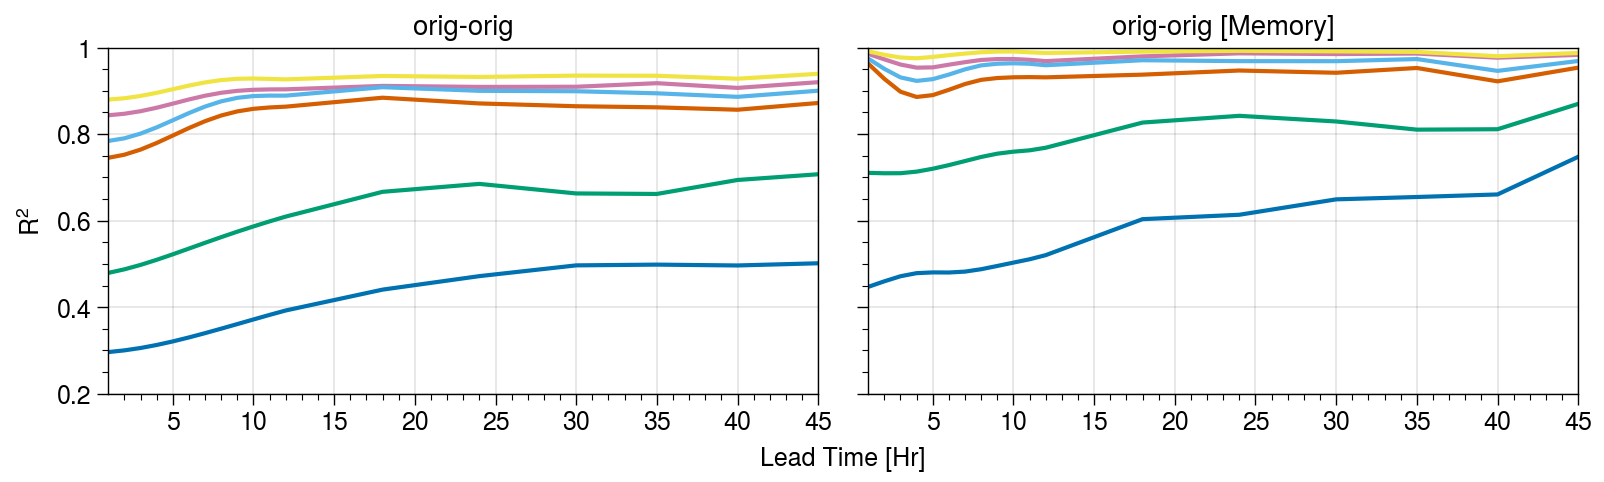

In [20]:
fig,axs = plot.subplots(ncols=2,nrows=1,axwidth=3.55,refaspect=2.051)
#axs[0].plot(LT,output_regscore(inTS=toin[0],outTS=toout,LTlist=LT,algorithm='linear'),label='u-v')
#axs[0].plot(LT,output_regscore(inTS=toin[1],outTS=toout,LTlist=LT,algorithm='linear'),label='u-v-w')
#axs[0].plot(LT,output_regscore(inTS=toin[2],outTS=toout,LTlist=LT,algorithm='linear'),label='u-v-qv')
#axs[0].plot(LT,output_regscore(inTS=toin[3],outTS=toout,LTlist=LT,algorithm='linear'),label='dtheta-u-v-w')
#axs[0].plot(LT,output_regscore(inTS=toin[4],outTS=toout,LTlist=LT,algorithm='linear'),label='dtheta-u-v-w-qv')
#axs[0].plot(LT,output_regscore(inTS=toin[5],outTS=toout,LTlist=LT,algorithm='linear'),label='u-v-w-qv')
#axs[0].legend(loc='b')
#axs[0].format(ylabel='R$^2$',xlabel='Lead Time [Hr]',title='TCr-TCr',ylim=[0.2,1])

axs[0].plot(LT,output_regscore(inTS=toin_o[0],outTS=toout_o,LTlist=LT,algorithm='linear'),label='u-v')
axs[0].plot(LT,output_regscore(inTS=toin_o[1],outTS=toout_o,LTlist=LT,algorithm='linear'),label='u-v-w')
axs[0].plot(LT,output_regscore(inTS=toin_o[2],outTS=toout_o,LTlist=LT,algorithm='linear'),label='u-v-qv')
axs[0].plot(LT,output_regscore(inTS=toin_o[3],outTS=toout_o,LTlist=LT,algorithm='linear'),label='dtheta-u-v-w')
axs[0].plot(LT,output_regscore(inTS=toin_o[4],outTS=toout_o,LTlist=LT,algorithm='linear'),label='dtheta-u-v-w-qv')
axs[0].plot(LT,output_regscore(inTS=toin_o[5],outTS=toout_o,LTlist=LT,algorithm='linear'),label='u-v-w-qv')
#axs[0].legend(loc='b')
axs[0].format(ylabel='R$^2$',xlabel='Lead Time [Hr]',title='orig-orig',ylim=[0.2,1])

axs[1].plot(LT,output_regscore_withmemory(inTS=toin_o[0],outTS=toout_o,LTlist=LT,algorithm='linear'),label='u-v')
axs[1].plot(LT,output_regscore_withmemory(inTS=toin_o[1],outTS=toout_o,LTlist=LT,algorithm='linear'),label='u-v-w')
axs[1].plot(LT,output_regscore_withmemory(inTS=toin_o[2],outTS=toout_o,LTlist=LT,algorithm='linear'),label='u-v-qv')
axs[1].plot(LT,output_regscore_withmemory(inTS=toin_o[3],outTS=toout_o,LTlist=LT,algorithm='linear'),label='dtheta-u-v-w')
axs[1].plot(LT,output_regscore_withmemory(inTS=toin_o[4],outTS=toout_o,LTlist=LT,algorithm='linear'),label='dtheta-u-v-w-qv')
axs[1].plot(LT,output_regscore_withmemory(inTS=toin_o[5],outTS=toout_o,LTlist=LT,algorithm='linear'),label='u-v-w-qv')
#axs[0].legend(loc='b')
axs[1].format(ylabel='R$^2$',xlabel='Lead Time [Hr]',title='orig-orig [Memory]',ylim=[0.2,1])

plt.savefig('./proc_fig/multilinear_r2_long.png',dpi=200)
plt.show()

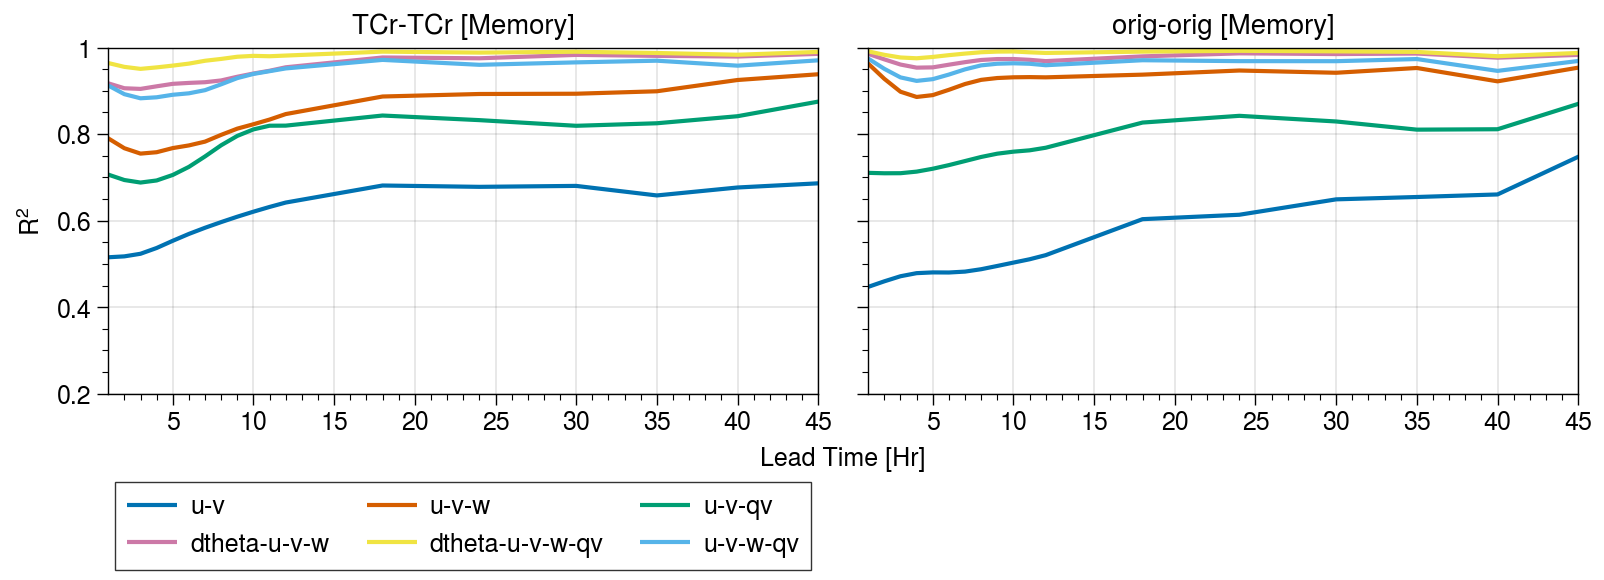

In [21]:
fig,axs = plot.subplots(ncols=2,nrows=1,axwidth=3.55,refaspect=2.051)
axs[0].plot(LT,output_regscore_withmemory(inTS=toin[0],outTS=toout,LTlist=LT,algorithm='linear'),label='u-v')
axs[0].plot(LT,output_regscore_withmemory(inTS=toin[1],outTS=toout,LTlist=LT,algorithm='linear'),label='u-v-w')
axs[0].plot(LT,output_regscore_withmemory(inTS=toin[2],outTS=toout,LTlist=LT,algorithm='linear'),label='u-v-qv')
axs[0].plot(LT,output_regscore_withmemory(inTS=toin[3],outTS=toout,LTlist=LT,algorithm='linear'),label='dtheta-u-v-w')
axs[0].plot(LT,output_regscore_withmemory(inTS=toin[4],outTS=toout,LTlist=LT,algorithm='linear'),label='dtheta-u-v-w-qv')
axs[0].plot(LT,output_regscore_withmemory(inTS=toin[5],outTS=toout,LTlist=LT,algorithm='linear'),label='u-v-w-qv')
axs[0].legend(loc='b')
axs[0].format(ylabel='R$^2$',xlabel='Lead Time [Hr]',title='TCr-TCr [Memory]',ylim=[0.2,1])

axs[1].plot(LT,output_regscore_withmemory(inTS=toin_o[0],outTS=toout_o,LTlist=LT,algorithm='linear'),label='u-v')
axs[1].plot(LT,output_regscore_withmemory(inTS=toin_o[1],outTS=toout_o,LTlist=LT,algorithm='linear'),label='u-v-w')
axs[1].plot(LT,output_regscore_withmemory(inTS=toin_o[2],outTS=toout_o,LTlist=LT,algorithm='linear'),label='u-v-qv')
axs[1].plot(LT,output_regscore_withmemory(inTS=toin_o[3],outTS=toout_o,LTlist=LT,algorithm='linear'),label='dtheta-u-v-w')
axs[1].plot(LT,output_regscore_withmemory(inTS=toin_o[4],outTS=toout_o,LTlist=LT,algorithm='linear'),label='dtheta-u-v-w-qv')
axs[1].plot(LT,output_regscore_withmemory(inTS=toin_o[5],outTS=toout_o,LTlist=LT,algorithm='linear'),label='u-v-w-qv')
#axs[0].legend(loc='b')
axs[1].format(ylabel='R$^2$',xlabel='Lead Time [Hr]',title='orig-orig [Memory]',ylim=[0.2,1])
plt.savefig('./proc_fig/multilinear_r2_long_memory.png',dpi=200)
plt.show()

In [58]:
def output_regpred(inTS=None,outTS=None,LTlist=None):
    return [produce_regscore(inTS[:-int(LTlist[i])],outTS[i][:-int(LTlist[i])],'predict') for i in range(len(outTS))]

In [73]:
print('2hr lead time, TCr-TCr (no moisture) / TCr-orig (no moisture)')
print([output_regscore(toin[0],outobj) for outobj in toout])
print('2hr lead time, orig-TCr (no moisture) / orig-orig (no moisture)')
print([output_regscore(toin[1],outobj) for outobj in toout])

2hr lead time, TCr-TCr (no moisture) / TCr-orig (no moisture)
[0.6382735722437431, 0.589800967865672]
2hr lead time, orig-TCr (no moisture) / orig-orig (no moisture)
[0.5931764343085771, 0.6783377174168802]


In [74]:
toin = [input_TCr[:-3],input_orig[:-3]]
toout = [output3_TCr[:-3],output3_orig[:-3]]

In [75]:
print('3hr lead time, TCr-TCr (no moisture) / TCr-orig (no moisture)')
print([output_regscore(toin[0],outobj) for outobj in toout])
print('3hr lead time, orig-TCr (no moisture) / orig-orig (no moisture)')
print([output_regscore(toin[1],outobj) for outobj in toout])

3hr lead time, TCr-TCr (no moisture) / TCr-orig (no moisture)
[0.6809300871003071, 0.6551529889220187]
3hr lead time, orig-TCr (no moisture) / orig-orig (no moisture)
[0.6369327321828429, 0.744916131767554]
